# Introduction

The dependencies are the following:

* numpy
* scipy
* pandas
* keras
* sklearn
* batman
* matplotlib

# Task 1 : Predicting the output of mascaret

The following modifications to the original dataset were applied for the first task

|   Dataset   | Train | Train | Train | Test | Test | Test |
|:-------:|:-----:|:-----:|:-----:|:----:|------|------|
|   Station   |  Ton  |  Lar  |  Mar  |  Ton | Lar  | Mar  |
|    dt   |   h   |   h   |   d   |   h  | h    | d    |
|  Interp |  Yes  |  Yes  |   No  |  Yes | Yes  | No   |
| Cleaned | No    | No    | No    | No   | No   | No   |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

input_H_L = pd.read_csv("data/H_Lareole_1996-2004.csv", parse_dates=True, index_col = 0)
input_Q_T = pd.read_csv("data/Q_Tonneins_1996-2004.csv", parse_dates=True, index_col = 0)
output_mas = pd.read_csv("data/mascaret_output_1996_2002.csv", parse_dates=True, index_col = 0)
solution_mas = pd.read_csv("data/mascaret_output_2003_2004.csv", parse_dates=True, index_col = 0)

print ("Shape of data : ", input_H_L.values.shape, input_Q_T.values.shape, solution_mas.values.shape) 

Shape of data :  (78912, 1) (78912, 1) (731, 1)


In [2]:
## Create train and validation and test set
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_H = input_H_L["1996-01-05":"2002-12-30"]
X_train_Q = input_Q_T["1996-01-05":"2002-12-30"]
X_train = np.concatenate((X_train_H.values, X_train_Q.values), axis=1)
y_train_mas = output_mas["1996-01-06":"2002"] #No data for Marmande before the 6

X_test_H = input_H_L["2002-12-31":"2004-12-30"]
X_test_Q = input_Q_T["2002-12-31":"2004-12-30"]
X_test = np.concatenate((X_test_H.values, X_test_Q.values), axis=1)
y_test_mas = solution_mas["2003":"2004"]

from sklearn.preprocessing import StandardScaler

scaler_Xh = StandardScaler()
scaler_Xq = StandardScaler()
scaler_y_mas = StandardScaler()

scaler_Xh.fit(X_train_H)
scaler_Xq.fit(X_train_Q)
scaler_y_mas.fit(y_train_mas)


def h_to_d(field):
    return (np.reshape(field, (int(field.shape[0]/24), 24)))


scaled_X_train = np.concatenate((h_to_d(scaler_Xh.transform(X_train_H)), h_to_d(scaler_Xq.transform(X_train_Q))), axis=1)
scaled_y_train_mas = scaler_y_mas.transform(y_train_mas).ravel()

scaled_X_test = np.concatenate((h_to_d(scaler_Xh.transform(X_test_H)), h_to_d(scaler_Xq.transform(X_test_Q))), axis=1)
scaled_y_test_mas = scaler_y_mas.transform(y_test_mas).ravel()

In [3]:
print(scaled_X_train.shape)
print(scaled_y_train_mas.shape)

print(scaled_X_test.shape)
print(scaled_y_test_mas.shape)

(2552, 48)
(2552,)
(731, 48)
(731,)


## Regression

RMSE: 0.18497635719254957


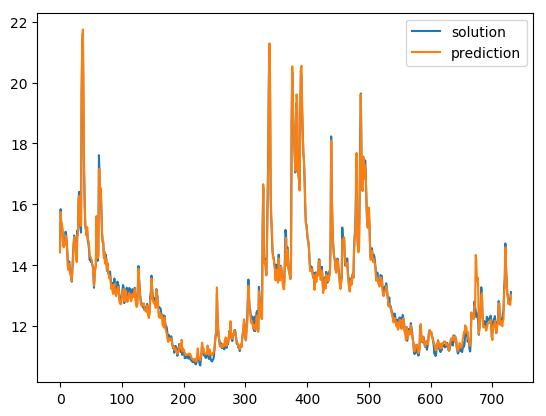

In [4]:
##The last hour at tonneins is the 23rd variable
reg_mas = linear_model.LinearRegression().fit(scaled_X_train[:, 23:24], scaled_y_train_mas)
reg_pred_mas = scaler_y_mas.inverse_transform(reg_mas.predict(scaled_X_test[:, 23:24]))

#print (mean_absolute_error(y_test_mas.values, reg_pred_mas))
print('RMSE:', np.sqrt(mean_squared_error(y_test_mas.values, reg_pred_mas)))

plt.plot(y_test_mas.values, label='solution')
plt.plot(reg_pred_mas, label='prediction')

plt.legend()
plt.show()

In [5]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print('R2:', r2_score(y_test_mas.values, reg_pred_mas))

R2: 0.9904802329938927


## Metrics

In [6]:
def FER_mas(predictions):
    """Fraction of explained residual."""
    predictions = predictions.reshape(-1, 1)
    true_vals = y_test_mas.values.reshape(-1, 1)
    reference = reg_pred_mas.reshape(-1, 1)
    return (1 - ( np.sum((true_vals-predictions) ** 2) / np.sum((true_vals-reference) ** 2) ))

def print_metrics_mas(predictions):
    predictions = predictions.reshape(-1, 1)
    true_vals = y_test_mas.values.reshape(-1, 1)
    reference = reg_pred_mas.reshape(-1, 1)
    print(f"R^2 score:{r2_score(true_vals, predictions)}\n"
          f"MSE:{mean_squared_error(true_vals, predictions)}\n"
          f"RMSE (cm):{100 * np.sqrt(mean_squared_error(true_vals, predictions))}\n"
          f"Error max (cm):{100 * np.max(np.abs(true_vals - predictions)) }\n"
          f"FER:{FER_mas(predictions)}")

## ML

In [7]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

GB_mas = GradientBoostingRegressor(n_estimators=70, max_depth=7, min_samples_split=2, min_samples_leaf=1)
GB_mas.fit(scaled_X_train, scaled_y_train_mas)
GB_pred_mas = scaler_y_mas.inverse_transform(GB_mas.predict(scaled_X_test))

RF_mas = RandomForestRegressor(n_estimators=50, max_depth=9, min_samples_split=2, min_samples_leaf=1)
RF_mas.fit(scaled_X_train, scaled_y_train_mas)
RF_pred_mas = scaler_y_mas.inverse_transform(RF_mas.predict(scaled_X_test))
  
print("Metrics for Gradient Boosting:")
print_metrics_mas(GB_pred_mas)

print("\nMetrics for Random Forest:")
print_metrics_mas(RF_pred_mas)

Metrics for Gradient Boosting:
R^2 score:0.9993463638480231
MSE:0.00234932007776754
RMSE (cm):4.846978520447084
Error max (cm):72.03609115238478
FER:0.9313390599205265

Metrics for Random Forest:
R^2 score:0.9992863128161497
MSE:0.0025651574277126476
RMSE (cm):5.06473832267043
Error max (cm):75.53599999999996
FER:0.9250310240374058


## DL

In [8]:
#First MLP with STANDARDIZED data
import keras
import keras.regularizers as kr
from keras import backend as K

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
K.clear_session()

from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

batch_size = 16
num_labels = 1
initial_LR = 0.002
Decay_LR = 0.8
epochs = 300

#steps_DL = 10

model_load = True

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(48,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_labels))

#LOAD model
#initial_LR = 0.0005
#name_model = "save_model/DL/model_mascarettest.h5"
#model = load_model(name_model)

adam = keras.optimizers.Adam(lr=initial_LR)
model.compile(loss='mse',
              optimizer=adam,
              metrics=['mae'])

def scheduler(epoch):
   initial_lrate = K.get_value(model.optimizer.lr)
   if epoch%10==9  :
       lrate = initial_lrate * Decay_LR
       print ("lrate = ", lrate)
       return lrate
   return initial_lrate

lrate = keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

filepath="save_model/DL/model_mascarettest.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)

if not model_load:
        history = model.fit(scaled_X_train, scaled_y_train_mas,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(scaled_X_test, scaled_y_test_mas), shuffle=True, callbacks=[lrate, checkpoint])
    
model_mas = load_model("save_model/DL/model_mascaret.h5")

DL_pred_mas = scaler_y_mas.inverse_transform(model_mas.predict(scaled_X_test))

print("Metrics for MLP:")
print_metrics_mas(DL_pred_mas)

Using TensorFlow backend.


Metrics for MLP:
R^2 score:0.999520600774955
MSE:0.0017230721116909893
RMSE (cm):4.150990377838751
Error max (cm):66.69725036621088
FER:0.9496417060693365


## DL conv

In [9]:
#First MLP with STANDARDIZED data

import keras
import keras.regularizers as kr
from keras import backend as K

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
K.clear_session()

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPool1D
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

model_load = True

batch_size = 128
num_labels = 1
initial_LR = 0.005
Decay_LR = 0.8
epochs = 400

def to_3d(field):
    return(np.reshape(field, (int(field.shape[0]), 24, 2), order="F"))


steps = 8

X_train_3D = to_3d(scaled_X_train)[:, -steps:, :]
scaled_X_test_3D = to_3d(scaled_X_test)[:, -steps:, :]
#X_test_3D = to_3d(X_test)[:, -steps:, :]


model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(steps, 2)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(num_labels))

#LOAD model
#initial_LR = 0.0005
#name_model = "save_model/model_convmascaret2.h5"
#model = load_model(name_model)

adam = keras.optimizers.Adam(lr=initial_LR)
model.compile(loss='mse',
              optimizer=adam,
              metrics=['mae'])

def scheduler(epoch):
   initial_lrate = K.get_value(model.optimizer.lr)
   if epoch%10==5  :
       lrate = initial_lrate * Decay_LR
       print ("lrate = ", lrate)
       return lrate
   return initial_lrate

lrate = keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

filepath="save_model/DL/model_convmascarettest.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)

if not model_load:
    history = model.fit(X_train_3D, scaled_y_train_mas,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(scaled_X_test_3D, scaled_y_test_mas), shuffle=True, callbacks=[lrate, checkpoint])

model_mas = load_model("save_model/DL/model_convmascaret.h5")

conv_pred_mas = scaler_y_mas.inverse_transform(model_mas.predict(scaled_X_test_3D))
    
print("Metrics for conv:")
print_metrics_mas(conv_pred_mas)

Metrics for conv:
R^2 score:0.9993759371970704
MSE:0.002243026595570315
RMSE (cm):4.736060172306001
Error max (cm):71.87536010742193
FER:0.9344455801776204


## Gaussian Process Regressor

In [10]:
import scipy.stats as st
from sklearn.decomposition import PCA
from batman.functions import DbGeneric
from batman.space import Space
from batman.surrogate import SurrogateModel

In [11]:
n_hours = 18
nh = 24 - n_hours

q_nh = h_to_d(X_train_Q.values)[:, nh:]
h_nh = h_to_d(X_train_H.values)[:, nh:]

print(f'Training sample:\n f(q, h) -> h with shapes:\n-> q: {q_nh.shape}\n-> h: {h_nh.shape}\n-> y: {y_train_mas.shape}\n')

q_nh_test = h_to_d(X_test_Q.values)[:, nh:]
h_nh_test = h_to_d(X_test_H.values)[:, nh:]

print(f'Testing sample:\n f(q, h) -> h with shapes:\n-> q: {q_nh_test.shape}\n-> h: {h_nh_test.shape}')

Training sample:
 f(q, h) -> h with shapes:
-> q: (2552, 18)
-> h: (2552, 18)
-> y: (2552, 1)

Testing sample:
 f(q, h) -> h with shapes:
-> q: (731, 18)
-> h: (731, 18)


In [12]:
# Data reduction
pca_q_nh = PCA(n_components=10, svd_solver='full')
data_r_q_nh = pca_q_nh.fit_transform(q_nh)

n_components = len(pca_q_nh.explained_variance_ratio_)
print(f'Number of components explaining matrice q: {n_components}')

pca_h_nh = PCA(n_components=2, svd_solver='full')
data_r_h_nh = pca_h_nh.fit_transform(h_nh)

n_components = len(pca_h_nh.explained_variance_ratio_)
print(f'Number of components explaining matrice h: {n_components}')

data_r_nh = np.concatenate([data_r_h_nh, data_r_q_nh], axis=1)

# This represents the bounds of the reduce matrix. Required by Batman.
corners_r_nh = np.array([data_r_nh.min(axis=0), data_r_nh.max(axis=0)])

Number of components explaining matrice q: 10
Number of components explaining matrice h: 2


In [13]:
# Defining learning space size
resamp = False

if resamp:
    # Subsample dataset uniformly
    f_database = DbGeneric(space=data_r_nh, data=y_train_mas)

    # Sought
    space_sought = Space(corners_r_nh)
    n_samples = 500
    space_sought.sampling(n_samples, kind="olhs")  # sobolscramble

    # From database
    space, data = f_database(space_sought, full=True)

    sample_ = space
    data_ = data
else:
    sample_ = data_r_nh[:728]
    data_ = y_train_mas.values[:728].reshape(-1, 1)
    
print(f'Learning sample of shape: {sample_.shape}')

Learning sample of shape: (728, 12)


In [14]:
# Surrogate model
model_load = True

model_nh = SurrogateModel('kriging', corners_r_nh, plabels=None, noise=True, global_optimizer=False)

if model_load:
    model_nh.read('save_model/pGP-task1')
else:
    model_nh.fit(sample_, data_)
    model_nh.write('save_model/pGP-task1')

/Users/roy/Applications/miniconda3/envs/batman3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.20.0 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/roy/Documents/Codes/batman/batman/space/sample.py:101: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  uniq, pos = np.unique(index.labels[0], return_index=True)
Ignoring Points - Out of Space - [[ 1.527e+01  5.620e+00  7.846e+03 -2.608e+03  4.755e+02 -2.550e+02
   4.778e+01  6.628e+01  1.852e+01  1.031e+01 -2.863e-01 -4.010e+00]
 [ 7.274e+00  2.876e+00  3.784e+03 -1.516e+03  7.662e+01 -1.715e+02
   1.678e+02 -3.400e+01 -4.396e+01  2.866e+01  9.148e+00 -1.134e+00]
 [ 9.075e+00  3.141e+00  3.967e+03 -8.126e+01  1.917e+02  4.819e+00
  -6.791e+01  6.241e+00 -5.404e+01  5.688e-01 -9.085e+00  2.390e+01]
 [ 2.234e+01  4.228e+00  1.110e+04 -2.249e+03  4.204e+02

In [15]:
# Prediction on the test samples
data_r_test_q_nh = pca_q_nh.transform(q_nh_test)
data_r_test_h_nh = pca_h_nh.transform(h_nh_test)
data_r_test_nh = np.concatenate([data_r_test_h_nh, data_r_test_q_nh], axis=1)

In [16]:
# Predictions
pred_nh_mas, pred_nh_var_mas = model_nh(data_r_test_nh)

In [17]:
# To file and std
pgp_solution_mas = y_test_mas.copy()  # We use the index of this fake solution which contained 0 only as values

print("shape : ", y_test_mas.values.shape, pred_nh_mas.shape)
pgp_solution_mas['height'] = pred_nh_mas
#pgp_solution.to_csv("garonne_test_pGP.predict")  # We then erase it with our prediction

pgp_std_mas = y_test_mas.copy()
pgp_std_mas['height'] = np.sqrt(pred_nh_var_mas) * st.norm.interval(0.95)

shape :  (731, 1) (731, 1)


In [18]:
# Metrics
print("Metrics for pGP:")
print_metrics_mas(pred_nh_mas)

Metrics for pGP:
R^2 score:0.9996297867218937
MSE:0.0013306324698850278
RMSE (cm):3.6477835323453993
Error max (cm):60.148431030253136
FER:0.961111098846354


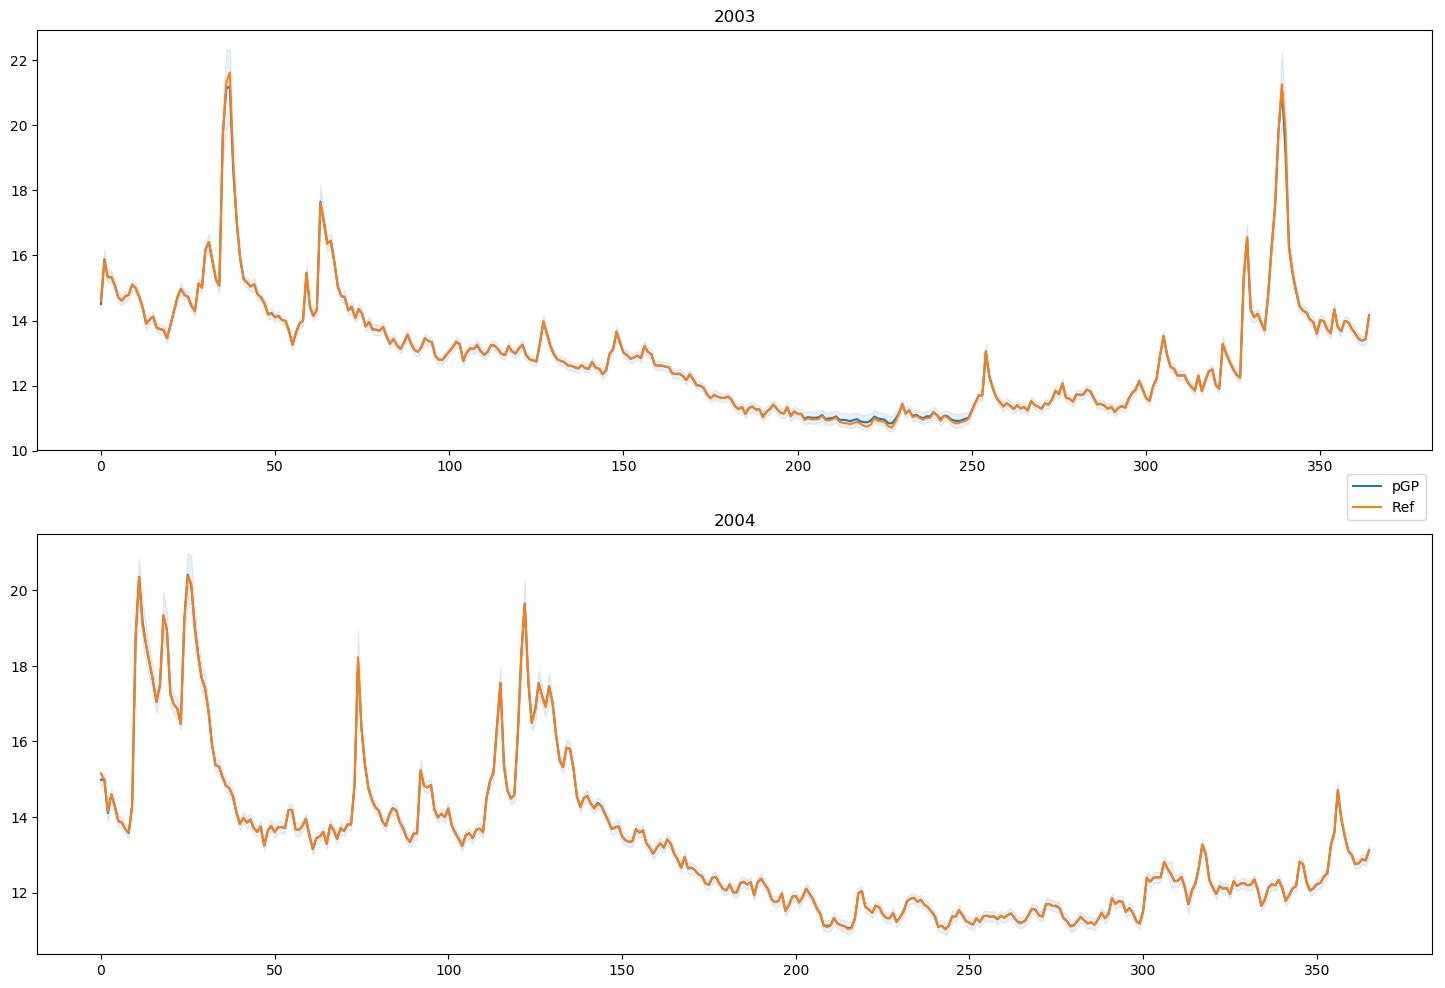

In [19]:
# Visualization of the predictions
figure = plt.figure(figsize=(18, 12))
grid = plt.GridSpec(2, 1, hspace=0.2, wspace=0.2)

figure.add_subplot(grid[0, 0])
plt.title('2003')
plt.fill_between(np.arange(len(pgp_solution_mas['2003'].values)),
                 pgp_solution_mas['2003']['height'].values - pgp_std_mas['2003']['height'].values,
                 pgp_solution_mas['2003']['height'].values + pgp_std_mas['2003']['height'].values,
                 alpha=0.1, color='C0')
plt.plot(pgp_solution_mas['2003'].values, label="pGP 2003", c='C0')

#plt.plot(reg_solution['2003'].values, label="Reg 2003")

plt.plot(y_test_mas['2003'].values, label="Ref 2003", c='C1')

figure.add_subplot(grid[1, 0])
plt.title('2004')
plt.fill_between(np.arange(len(pgp_solution_mas['2004'].values)),
                 pgp_solution_mas['2004']['height'].values - pgp_std_mas['2004']['height'].values,
                 pgp_solution_mas['2004']['height'].values + pgp_std_mas['2004']['height'].values,
                 alpha=0.1, color='C0')
plt.plot(pgp_solution_mas['2004'].values, label="pGP 2004", c='C0')

#plt.plot(reg_solution['2004'].values, label="Reg 2004")

plt.plot(y_test_mas['2004'].values, label="Ref 2004", c='C1')

plt.legend(['pGP', 'Ref'], bbox_to_anchor=(1, 1.16))
plt.show()

# Task 2 : Predicting the observed values

The following modifications to the original dataset were applied for the second task

|   Dataset   | Train | Train | Train | Test | Test | Test |
|:-------:|:-----:|:-----:|:-----:|:----:|------|------|
|   Station   |  Ton  |  Lar  |  Mar  |  Ton | Lar  | Mar  |
|    dt   |   h   |   h   |   h   |   h  |  h    | h    |
|  Interp |  Yes  |  Yes  |   Yes  |  Yes | Yes  | Yes   |
| Cleaned | No    | No    | No    | Yes   | No   | No   |

In [20]:
####Task 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

input_H_L = pd.read_csv("data/cleaned_H_Lareole_1996-2004.csv", parse_dates=True, index_col = 0)
input_Q_T = pd.read_csv("data/cleaned_Q_Tonneins_1996-2004.csv", parse_dates=True, index_col = 0)
output = pd.read_csv("data/cleaned_output_1996-2002.csv", parse_dates=True, index_col = 0)
solution = pd.read_csv("data/cleaned_output_2003-2004.csv", parse_dates=True, index_col = 0)

print("Shape of data : ", input_H_L.values.shape, input_Q_T.values.shape, solution.values.shape) 

Shape of data :  (78912, 1) (78912, 1) (17544, 1)


In [21]:
## Create train and validation and test set
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_H = input_H_L["1996-01-06":"2002"]
X_train_Q = input_Q_T["1996-01-06":"2002"]
X_train = np.concatenate((X_train_H.values, X_train_Q.values), axis=1)
y_train = output["1996-01-06":"2002"] #No data for Marmande before the 6


X_test_H = input_H_L["2002-12-31":"2004"]
X_test_Q = input_Q_T["2002-12-31":"2004"]

X_test = np.concatenate((X_test_H.values, X_test_Q.values), axis=1)
y_test = solution["2003":"2004"]

from sklearn.preprocessing import StandardScaler

scaler_Xh = StandardScaler()
scaler_Xq = StandardScaler()
scaler_y = StandardScaler()

scaler_Xh.fit(X_train_H)
scaler_Xq.fit(X_train_Q)
scaler_y.fit(y_train)

scaled_X_train = np.concatenate((scaler_Xh.transform(X_train_H), scaler_Xq.transform(X_train_Q)), axis=1)
scaled_y_train = scaler_y.transform(y_train)

scaled_X_test = np.concatenate((scaler_Xh.transform(X_test_H), scaler_Xq.transform(X_test_Q)), axis=1)
scaled_y_test = scaler_y.transform(y_test)

## Regression

MAE: 0.11086191551922189


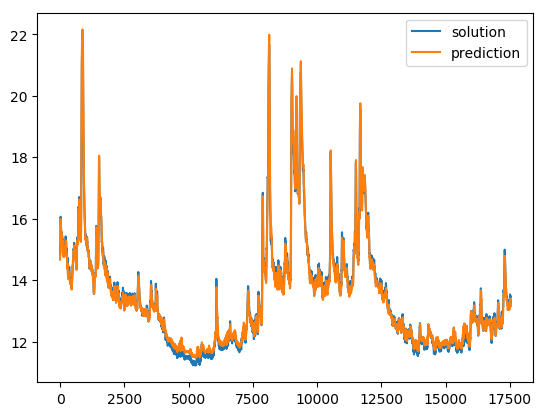

In [22]:
steps_reg = 24

reg = linear_model.LinearRegression().fit(scaled_X_train, scaled_y_train)
reg_pred = scaler_y.inverse_transform(reg.predict(scaled_X_test[steps_reg:]))

print('MAE:', mean_absolute_error(y_test.values, reg_pred))

plt.plot(y_test.values, label='solution')
plt.plot(reg_pred, label='prediction')

plt.legend()
plt.show()

In [23]:
from sklearn.metrics import r2_score
print('R2:', r2_score(y_test.values, reg_pred))


R2: 0.9925970914052731


## Metrics

In [24]:
def FER(predictions):
    """Fraction of explained residual."""
    predictions = predictions.reshape(-1, 1)
    true_vals = y_test.values.reshape(-1, 1)
    reference = reg_pred.reshape(-1, 1)
    return (1 - ( np.sum((true_vals-predictions) ** 2) / np.sum((true_vals-reference) ** 2) ))

def print_metrics(predictions):
    predictions = predictions.reshape(-1, 1)
    true_vals = y_test.values.reshape(-1, 1)
    reference = reg_pred.reshape(-1, 1)
    print(f"R^2 score: {r2_score(true_vals, predictions)}\n"
          f"MSE: {mean_squared_error(true_vals, predictions)}\n"
          f"RMSE (cm): {100 * np.sqrt(mean_squared_error(true_vals, predictions))}\n"
          f"Error max (cm): {100 * np.max(np.abs(true_vals - predictions)) }\n"
          f"FER: {FER(predictions)}")

## ML

In [25]:
#Useful fonctions
from time import time

def get_inputs(data, num, step):
    liste_inputs = data[num+1-step:num+1]
    liste_ravel = np.ravel(liste_inputs.T)
    return liste_ravel

def get_inputs_3D(data, num, step):
    liste_inputs = data[num+1-step:num+1]
    #liste_ravel = np.ravel(liste_inputs.T)
    return liste_inputs

In [26]:
#Calcul and write results on true solution
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

steps_ML = 10
X_train_steps = np.array([get_inputs(scaled_X_train, k, steps_ML) for k in range(steps_ML, scaled_X_train.shape[0])])
y_train_steps = scaled_y_train[steps_ML:].ravel()

X_steps = scaled_X_test[-y_test.shape[0]-steps_ML:]
X_test_steps = np.array([get_inputs(X_steps, k, steps_ML) for k in range(steps_ML, X_steps.shape[0])])
y_test_steps = y_test.values.ravel()

GB = GradientBoostingRegressor(n_estimators=70, max_depth=7, min_samples_split=2, min_samples_leaf=1)
GB.fit(X_train_steps, y_train_steps)
GB_pred = scaler_y.inverse_transform(GB.predict(X_test_steps))

RF = RandomForestRegressor(n_estimators=50, max_depth=9, min_samples_split=2, min_samples_leaf=1)
RF.fit(X_train_steps, y_train_steps)
RF_pred = scaler_y.inverse_transform(RF.predict(X_test_steps))
  
print("Metrics for Random forest:")
print_metrics(RF_pred)

print("\nMetrics for Gradient Bossting:")
print_metrics(GB_pred)

Metrics for Random forest:
R^2 score: 0.9980578328840093
MSE: 0.005932886629691628
RMSE (cm): 7.702523372046091
Error max (cm): 104.92355194805185
FER: 0.7376481026154831

Metrics for Gradient Bossting:
R^2 score: 0.9981447805726754
MSE: 0.005667280866251992
RMSE (cm): 7.528134474258541
Error max (cm): 106.31178499501068
FER: 0.7493931738335847


## DL

In [27]:
#First MLP with STANDARDIZED data
import keras
import keras.regularizers as kr
from keras import backend as K

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
K.clear_session()

from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

model_load = True

batch_size = 48
num_labels = 1
initial_LR = 0.01
Decay_LR = 0.8
epochs = 300

steps_DL = 24
X_train_steps = np.array([get_inputs(scaled_X_train, k, steps_DL) for k in range(steps_DL, scaled_X_train.shape[0])])
y_train_steps = scaled_y_train[steps_DL:].ravel()
X_steps = scaled_X_test[-y_test.shape[0]-steps_DL:]
X_test_steps = np.array([get_inputs(X_steps, k, steps_DL) for k in range(steps_DL, X_steps.shape[0])])
y_test_steps = scaled_y_test.ravel()

print("shape test : ", y_test_steps.shape, X_test_steps.shape)
print("shape train : ", y_train_steps.shape, X_train_steps.shape)

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(2*steps_DL,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_labels))

#LOAD model
#initial_LR = 0.0005
#name_model = "save_model/model.h5"
#model = load_model(name_model)

adam = keras.optimizers.Adam(lr=initial_LR)
model.compile(loss='mse',
              optimizer=adam,
              metrics=['mae'])

def scheduler(epoch):
   initial_lrate = K.get_value(model.optimizer.lr)
   if epoch%10==9  :
       lrate = initial_lrate * Decay_LR
       print ("lrate = ", lrate)
       return lrate
   return initial_lrate

lrate = keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

filepath="save_model/DL/model_obstest.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

if not model_load:
        history = model.fit(X_train_steps, y_train_steps,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True, callbacks=[lrate, checkpoint])

    
model = load_model("save_model/DL/model_obs.h5")

DL_pred = scaler_y.inverse_transform(model.predict(X_test_steps))

print("Metrics for MLP:")
print_metrics(DL_pred)

shape test :  (17544,) (17544, 48)
shape train :  (61224,) (61224, 48)
Metrics for MLP:
R^2 score: 0.9989420994527417
MSE: 0.0032316498208088216
RMSE (cm): 5.684760171554137
Error max (cm): 76.00525665283193
FER: 0.8570966352317445


## DL conv

In [28]:
#First MLP with STANDARDIZED data
import keras
import keras.regularizers as kr
from keras import backend as K

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
K.clear_session()

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPool1D
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

model_load = True

batch_size = 128
num_labels = 1
initial_LR = 0.01
Decay_LR = 0.7
epochs = 300

steps = 8

X_train_3D = np.array([get_inputs_3D(scaled_X_train, k, steps) for k in range(steps, scaled_X_train.shape[0])])
y_train_steps = scaled_y_train[steps:].ravel()

X_steps = scaled_X_test[-y_test.shape[0]-steps:]
X_test_3D = np.array([get_inputs_3D(X_steps, k, steps) for k in range(steps, X_steps.shape[0])])
y_test_steps = y_test.values.ravel()
scaled_y_test_steps = scaled_y_test.ravel()


model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(steps, 2)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(num_labels))

#LOAD model
#initial_LR = 0.0005
#name_model = "save_model/model_convbig.h5"
#model = load_model(name_model)

adam = keras.optimizers.Adam(lr=initial_LR)
model.compile(loss='mse',
              optimizer=adam,
              metrics=['mae'])

def scheduler(epoch):
   initial_lrate = K.get_value(model.optimizer.lr)
   if epoch%10==5  :
       lrate = initial_lrate * Decay_LR
       print ("lrate = ", lrate)
       return lrate
   return initial_lrate

lrate = keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

filepath="save_model/DL/model_convobstest.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)

if not model_load:
    history = model.fit(X_train_3D, y_train_steps,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_test_3D, scaled_y_test_steps), shuffle=True, callbacks=[lrate, checkpoint])

model = load_model("save_model/DL/model_convobs.h5")

conv_pred = scaler_y.inverse_transform(model.predict(X_test_3D))
    
print("Metrics for conv:")
print_metrics(conv_pred)

Metrics for conv:
R^2 score: 0.999190250679754
MSE: 0.0024736032630429386
RMSE (cm): 4.973533213966645
Error max (cm): 48.19715499877937
FER: 0.890617409375716


## Gaussian Process Regressor

In [29]:
import scipy.stats as st
from sklearn.decomposition import PCA
from batman.functions import DbGeneric
from batman.space import Space
from batman.surrogate import SurrogateModel

In [30]:
n_hours = 9

y_nh = y_train.values[n_hours - 1:]
n_samples = y_nh.shape[0]

q_nh = np.zeros([n_samples, n_hours])
h_nh = np.zeros([n_samples, n_hours])

for i in range(n_samples - n_hours - 1):
    q_nh[i] = X_train_Q.values[i:i + n_hours].flatten()
    h_nh[i] = X_train_H.values[i:i + n_hours].flatten()


print(f'Training sample:\n f(q, h) -> h with shapes:\n-> q: {q_nh.shape}\n-> h: {h_nh.shape}\n-> y: {y_nh.shape}\n')

# Transform validation sample for n_hours
n_samples_test = 17544

q_nh_test = np.zeros([n_samples_test, n_hours])
h_nh_test = np.zeros([n_samples_test, n_hours])

input_H_ = input_H_L["2002-12-31":].values
input_Q_ = input_Q_T["2002-12-31":].values

step = 24 - n_hours + 1

for i in range(n_samples_test):
    q_nh_test[i] = input_Q_[step + i:step + i + n_hours].flatten()
    h_nh_test[i] = input_H_[step + i:step + i + n_hours].flatten()

print(f'Testing sample:\n f(q, h) -> h with shapes:\n-> q: {q_nh_test.shape}\n-> h: {h_nh_test.shape}')

Training sample:
 f(q, h) -> h with shapes:
-> q: (61240, 9)
-> h: (61240, 9)
-> y: (61240, 1)

Testing sample:
 f(q, h) -> h with shapes:
-> q: (17544, 9)
-> h: (17544, 9)


In [31]:
# Data reduction
pca_q_nh = PCA(n_components=4, svd_solver='full')
data_r_q_nh = pca_q_nh.fit_transform(q_nh)

n_components = len(pca_q_nh.explained_variance_ratio_)
print(f'Number of components explaining matrice q: {n_components}')

pca_h_nh = PCA(n_components=9, svd_solver='full')
data_r_h_nh = pca_h_nh.fit_transform(h_nh)

n_components = len(pca_h_nh.explained_variance_ratio_)
print(f'Number of components explaining matrice h: {n_components}')

data_r_nh = np.concatenate([data_r_h_nh, data_r_q_nh], axis=1)

# This represents the bounds of the reduce matrix. Required by Batman.
corners_r_nh = np.array([data_r_nh.min(axis=0), data_r_nh.max(axis=0)])

Number of components explaining matrice q: 4
Number of components explaining matrice h: 9


In [32]:
# Defining learning space size
resamp = False

if resamp:
    # Subsample dataset uniformly
    f_database = DbGeneric(space=data_r_nh, data=y_nh)

    # Sought
    space_sought = Space(corners_r_nh)
    n_samples = 680
    space_sought.sampling(n_samples, kind="olhs")  # sobolscramble

    # From database
    space, data = f_database(space_sought, full=True)

    sample_ = space
    data_ = data
else:
    sample_ = data_r_nh[::135]
    data_ = y_nh[::135].reshape(-1, 1)
    
print(f'Learning sample of shape: {sample_.shape}')

Learning sample of shape: (454, 13)


In [33]:
# Surrogate model
model_load = True

model_nh = SurrogateModel('kriging', corners_r_nh, plabels=None, noise=True, global_optimizer=False)

if model_load:
    model_nh.read('save_model/pGP')
else:
    model_nh.fit(sample_, data_)
    model_nh.write('save_model/pGP')

/Users/roy/Applications/miniconda3/envs/batman3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.20.0 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/roy/Documents/Codes/batman/batman/space/sample.py:101: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  uniq, pos = np.unique(index.labels[0], return_index=True)


In [34]:
# Prediction on the test samples
data_r_test_q_nh = pca_q_nh.transform(q_nh_test)
data_r_test_h_nh = pca_h_nh.transform(h_nh_test)
data_r_test_nh = np.concatenate([data_r_test_h_nh, data_r_test_q_nh], axis=1)

In [35]:
# Predictions
pred_nh, pred_nh_var = model_nh(data_r_test_nh)

In [36]:
# To file and std
pgp_solution = y_test.copy()  # We use the index of this fake solution which contained 0 only as values

print("shape : ", y_test.values.shape, pred_nh.shape)
pgp_solution['height'] = pred_nh
#pgp_solution.to_csv("garonne_test_pGP.predict")  # We then erase it with our prediction

pgp_std = y_test.copy()
pgp_std['height'] = np.sqrt(pred_nh_var) * st.norm.interval(0.95)

shape :  (17544, 1) (17544, 1)


In [37]:
print_metrics(pred_nh)

R^2 score: 0.998415692757125
MSE: 0.0048397046686588455
RMSE (cm): 6.956798594654617
Error max (cm): 63.63247328938151
FER: 0.7859885445562023


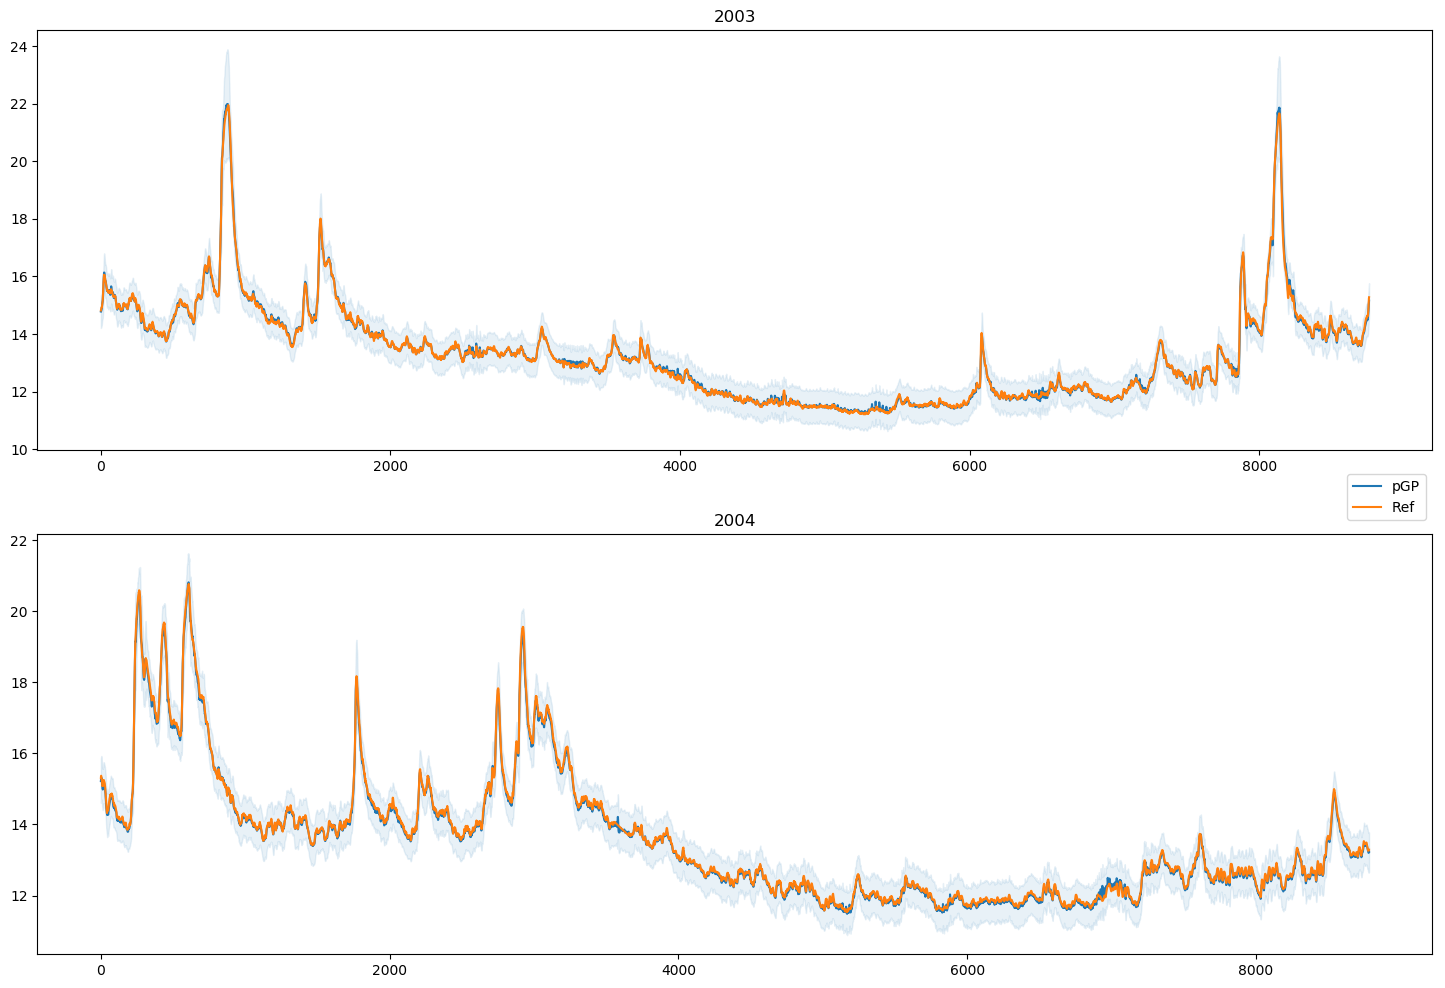

In [38]:
# Visualization of the predictions
figure = plt.figure(figsize=(18, 12))
grid = plt.GridSpec(2, 1, hspace=0.2, wspace=0.2)

figure.add_subplot(grid[0, 0])
plt.title('2003')
plt.fill_between(np.arange(len(pgp_solution['2003'].values)),
                 pgp_solution['2003']['height'].values - pgp_std['2003']['height'].values,
                 pgp_solution['2003']['height'].values + pgp_std['2003']['height'].values,
                 alpha=0.1, color='C0')
plt.plot(pgp_solution['2003'].values, label="pGP 2003", c='C0')

#plt.plot(reg_solution['2003'].values, label="Reg 2003")

plt.plot(y_test['2003'].values, label="Ref 2003", c='C1')

figure.add_subplot(grid[1, 0])
plt.title('2004')
plt.fill_between(np.arange(len(pgp_solution['2004'].values)),
                 pgp_solution['2004']['height'].values - pgp_std['2004']['height'].values,
                 pgp_solution['2004']['height'].values + pgp_std['2004']['height'].values,
                 alpha=0.1, color='C0')
plt.plot(pgp_solution['2004'].values, label="pGP 2004", c='C0')

#plt.plot(reg_solution['2004'].values, label="Reg 2004")

plt.plot(y_test['2004'].values, label="Ref 2004", c='C1')

plt.legend(['pGP', 'Ref'], bbox_to_anchor=(1, 1.16))
plt.show()

# Figures

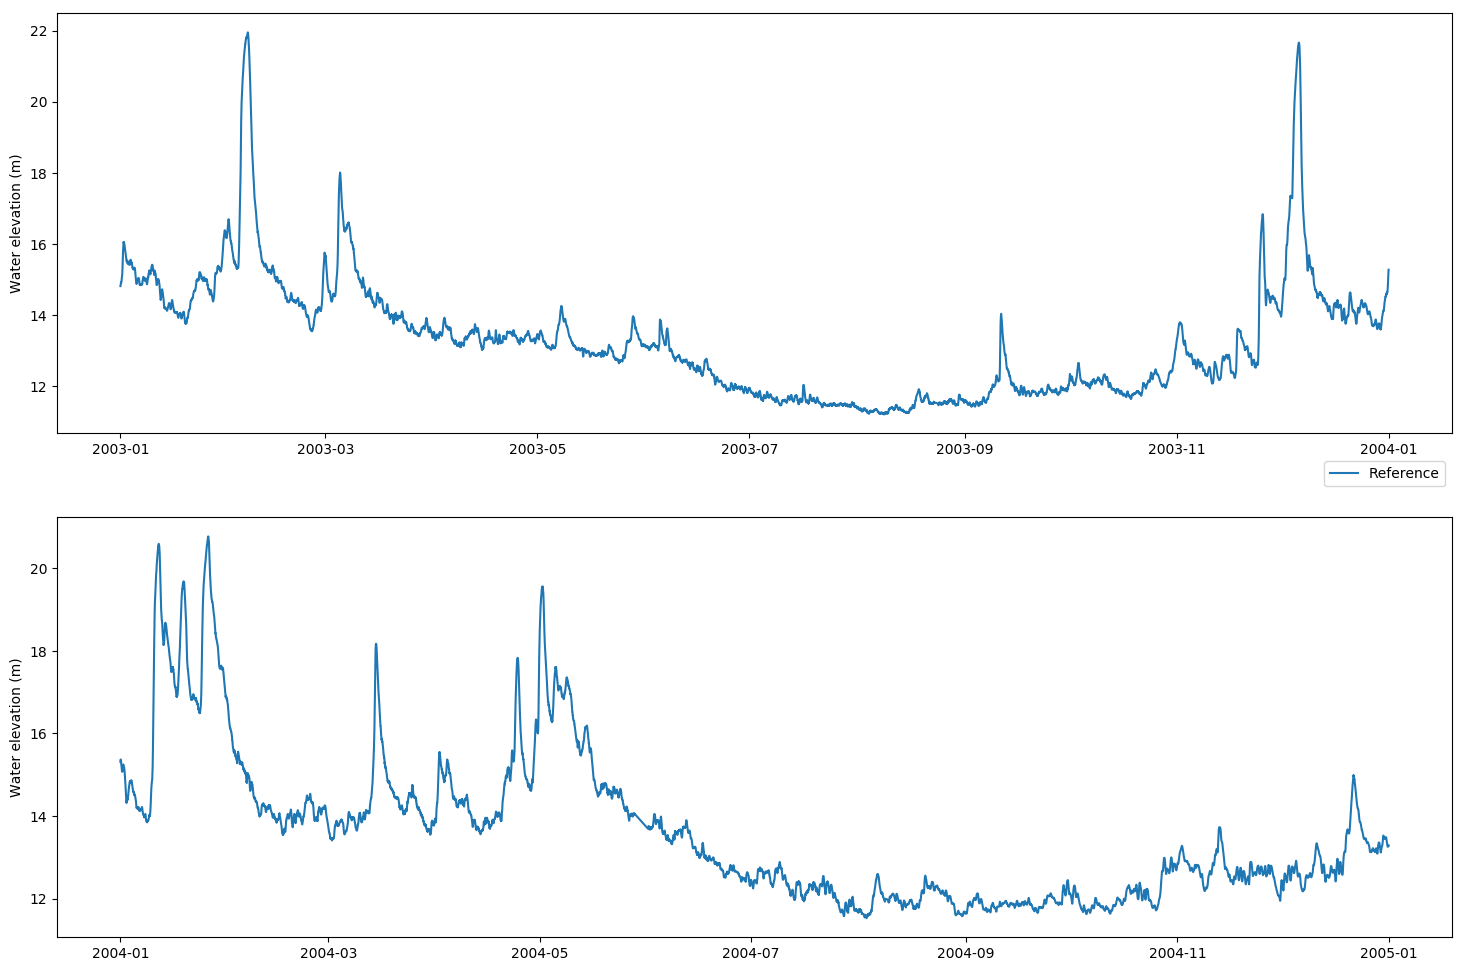

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(18, 12))

# 2003
axs[0].plot(y_test['2003'])
axs[0].set_ylabel('Water elevation (m)')

# 2004
axs[1].plot(y_test['2004'])
axs[1].set_ylabel('Water elevation (m)')

plt.legend(['Reference'], bbox_to_anchor=(1, 1.15))
plt.show()

fig.tight_layout()
fig.savefig('reference_task2.png')

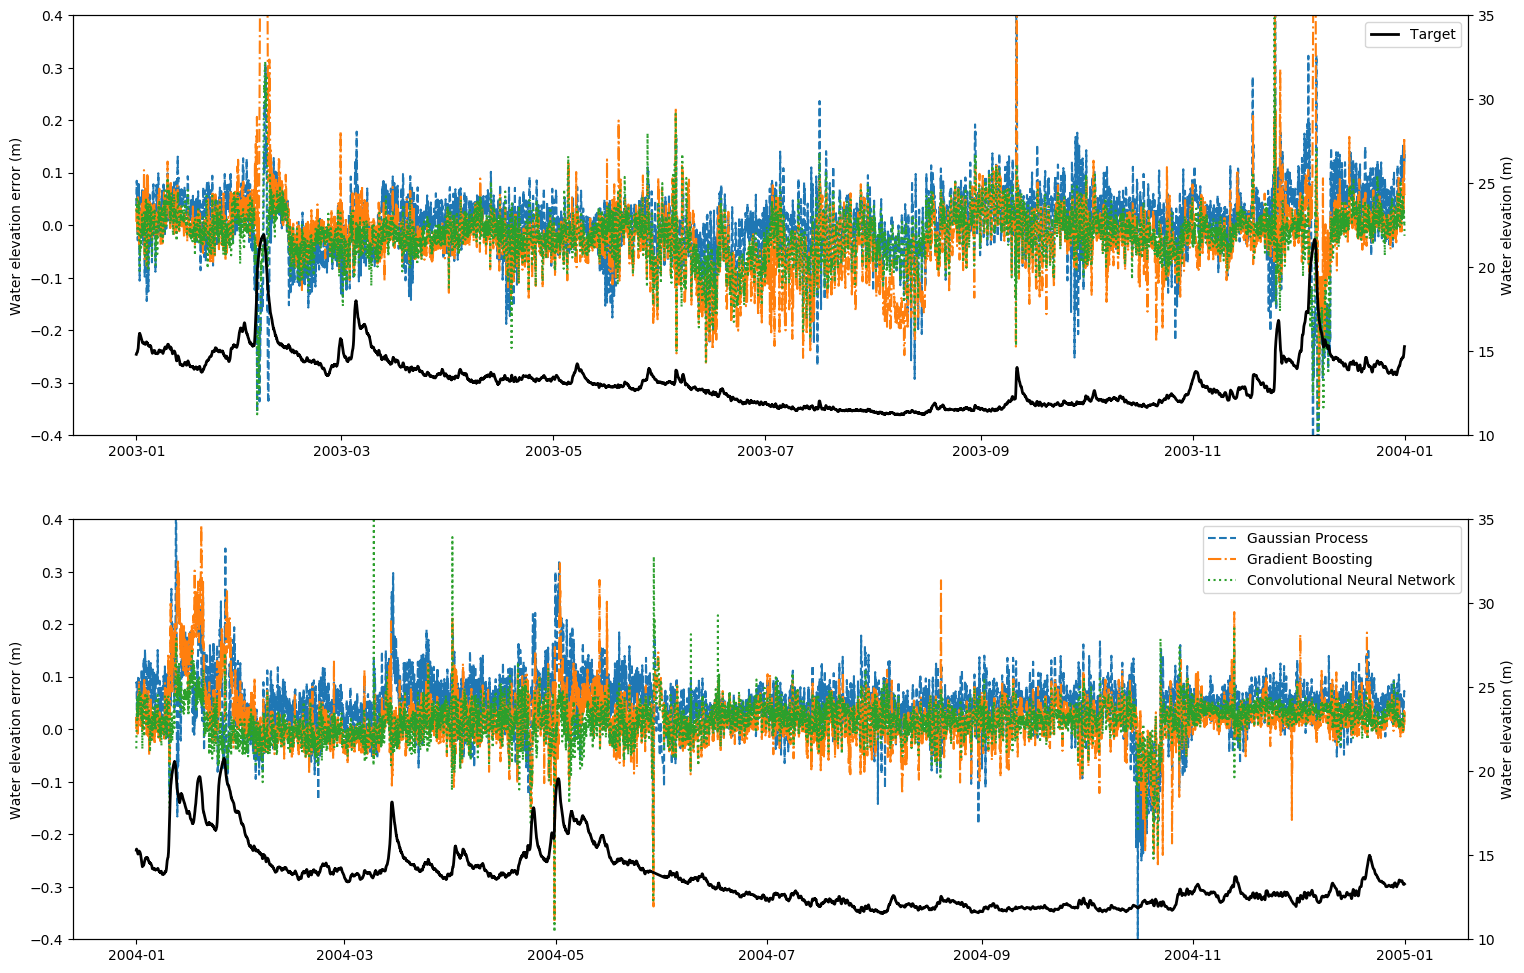

In [120]:
# Visualization of the predictions error with the reference
err_reg_pred = y_test - reg_pred.reshape(-1, 1)
err_GB_pred = y_test - GB_pred.reshape(-1, 1)
err_DL_pred = y_test - DL_pred.reshape(-1, 1)
err_conv_pred = y_test - conv_pred.reshape(-1, 1)
err_pgp_solution = y_test - pgp_solution

methods = [err_pgp_solution, err_GB_pred, err_conv_pred]
labels = ['Gaussian Process', 'Gradient Boosting', 'Convolutional Neural Network']
ls = ['--', '-.', ':']

fig, axs = plt.subplots(2, 1, figsize=(18, 12))

# 2003
for method, label, ls_ in zip(methods, labels, ls):
    axs[0].plot(method['2003'], label=label, ls=ls_)

axs[0].set_ylabel('Water elevation error (m)')
axs[0].set_ylim([-0.4, 0.4])

ax2 = axs[0].twinx()
ax2.plot(y_test['2003'], c='k', ls='-', lw=2, label='Target')
ax2.set_ylabel('Water elevation (m)')
ax2.set_ylim([10, 35])
ax2.legend()

# 2004
for method, label, ls_ in zip(methods, labels, ls):
    axs[1].plot(method['2004'], label=label, ls=ls_)

axs[1].set_ylabel('Water elevation error (m)')
axs[1].set_ylim([-0.4, 0.4])

ax2 = axs[1].twinx()
ax2.plot(y_test['2004'], c='k', ls='-', lw=2, label='Target')
ax2.set_ylabel('Water elevation (m)')
ax2.set_ylim([10, 35])

axs[1].legend()
plt.show()

fig.tight_layout()
fig.savefig('err_reference_task2.png', dpi=300)

/Users/roy/Applications/miniconda3/envs/batman3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/roy/Applications/miniconda3/envs/batman3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/roy/Applications/miniconda3/envs/batman3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarn

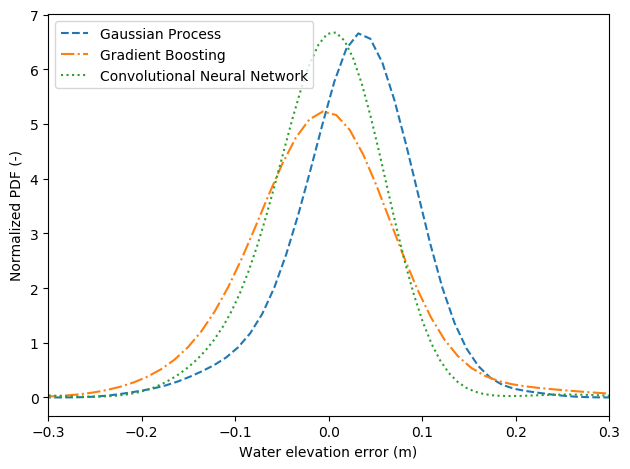

In [98]:
from batman.visualization.uncertainty import kernel_smoothing

labels = ['Gaussian Process', 'Gradient Boosting', 'Convolutional Neural Network']
ls = ['--', '-.', ':']
colors = ['C0', 'C1', 'C2']

fig, axs = plt.subplots(1, 1)

for i, sample in enumerate([err_pgp_solution.values, err_GB_pred.values, err_conv_pred.values]):
    x_plot = np.linspace(min(sample), max(sample), 100)[:, np.newaxis]
    _ks = kernel_smoothing(sample[::10], False)
    pdf = np.exp(_ks.score_samples(x_plot))
    axs.plot(x_plot, pdf, ls=ls[i], label=labels[i], c=colors[i])
    axs.set_xlim([-0.3, 0.3])

axs.set_ylabel('Normalized PDF (-)')
axs.set_xlabel('Water elevation error (m)')

plt.legend()
fig.tight_layout()
plt.show()
fig.savefig('pdf_err_task2.png', dpi=300)